# cloning the dataset

In [1]:
! git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

fatal: destination path 'clothing-dataset-small' already exists and is not an empty directory.


In [2]:
import os
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
base_dir = '/content/clothing-dataset-small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


In [4]:
os.listdir(train_dir)

['outwear',
 'skirt',
 'dress',
 'shirt',
 'hat',
 't-shirt',
 'pants',
 'longsleeve',
 'shoes',
 'shorts']

In [5]:
count = []
idx = {}
for i in os.listdir(train_dir):
    p = len(os.listdir(os.path.join(train_dir,i)))
    count.append(p)
    idx[i] = p

sum(idx.values())
#len(os.listdir(os.path.join(validation_dir,'skirt')))


3068

# plotting some statistics about the data 

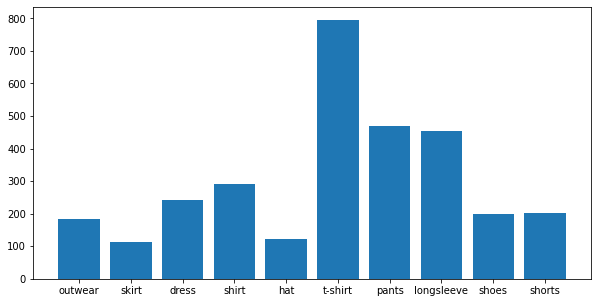

In [6]:
names = list(idx.keys())
values = list(idx.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(range(len(idx)), values, tick_label=names)
plt.show()

there is a class imbalance problem in this data , so we try to to use some class imbalance techniques. according to our proplem which is Computer vision proplem so we might use Focal Loss . is short its gives more weight for low data and low weight for high class data 

#  Let's instantiate the VGG16 model:



In [7]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Removing the Dense layers of the base network

In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

**there are two ways we could proceed:**



*   Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier . This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.

*   Extending the model we have (conv_base) by adding Dense layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.




In [9]:

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,10))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size)
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 3068)
validation_features, validation_labels = extract_features(validation_dir, 341)
test_features, test_labels = extract_features(test_dir, 372)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Found 372 images belonging to 10 classes.


The extracted features are currently of shape (samples, 4, 4, 512). We will feed them to a densely-connected classifier, so first we must flatten them to (samples, 8192)

In [10]:
train_features = np.reshape(train_features, (3068, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (341, 4 * 4 * 512))
test_features = np.reshape(test_features, (372, 4 * 4 * 512))

In [11]:
import keras.backend as K
import tensorflow as tf

def categorical_focal_loss(gamma=2., alpha=.25):

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)

    return categorical_focal_loss_fixed

In [12]:
from keras import models
from keras import layers
from keras import optimizers
#try to use focal loss in the loss category 

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001),
              loss=categorical_focal_loss(),
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=50,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


154/154 [==============================] - 2s 8ms/step - loss: 0.2413 - acc: 0.6076 - val_loss: 0.1763 - val_acc: 0.6158
Epoch 2/50
154/154 [==============================] - 1s 7ms/step - loss: 0.1004 - acc: 0.7552 - val_loss: 0.1124 - val_acc: 0.7537
Epoch 3/50
154/154 [==============================] - 1s 7ms/step - loss: 0.0670 - acc: 0.8168 - val_loss: 0.1055 - val_acc: 0.7742
Epoch 4/50
154/154 [==============================] - 1s 7ms/step - loss: 0.0485 - acc: 0.8566 - val_loss: 0.0878 - val_acc: 0.8182
Epoch 5/50
154/154 [==============================] - 1s 7ms/step - loss: 0.0381 - acc: 0.8862 - val_loss: 0.0827 - val_acc: 0.8152
Epoch 6/50
154/154 [==============================] - 1s 7ms/step - loss: 0.0293 - acc: 0.9094 - val_loss: 0.0986 - val_acc: 0.8387
Epoch 7/50
154/154 [==============================] - 1s 7ms/step - loss: 0.0245 - acc: 0.9241 - val_loss: 0.0908 - val_acc: 0.8534
Epoch 8/50
154/154 [==============================] - 1s 7ms/step - loss: 0.0232 - acc:

# using keras to Visualize

In [13]:
!pip install plot_keras_history


[(<Figure size 360x360 with 1 Axes>, <Figure size 360x360 with 1 Axes>),
 (<matplotlib.axes._subplots.AxesSubplot at 0x7fa54321ef90>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fa540381e10>)]

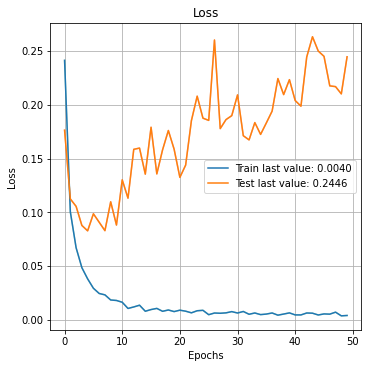

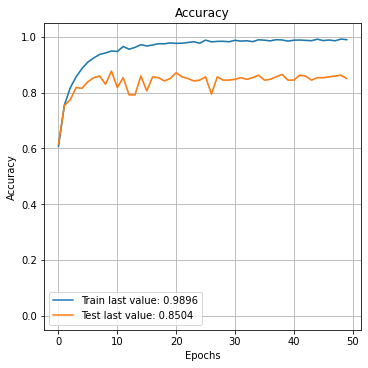

In [14]:
from plot_keras_history import plot_history

plot_history(history,single_graphs=True)


In [15]:
import matplotlib.pyplot as plt
def visualize(history):

  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()
  
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  
  plt.show()

# Visualizing the previous model using matplotlib


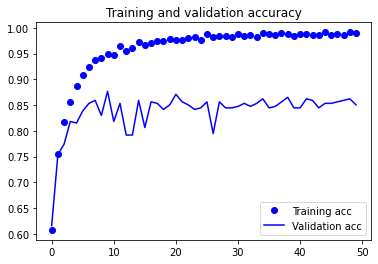

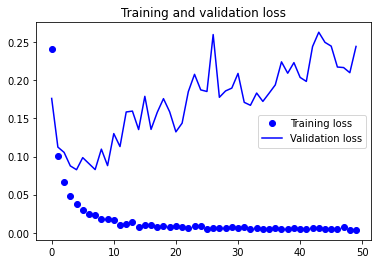

In [16]:
visualize(history)

so the model is overfitting , so we can try to increase regulization , dropout and try to use some Data Augmentation Technique

In [17]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))



In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 16,814,666
Trainable params: 16,814,666
Non-trainable params: 0
_________________________________________________________________


**thera are 16 M parameter in this model can be trained**

In [19]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))



This is the number of trainable weights before freezing the conv base: 30


In [20]:
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


# Data Augmentation

In [21]:

import math
BATCH_SIZE =32

TRAINING_SIZE = 3068

VALIDATION_SIZE = 341

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))

steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE)
val_steps = compute_steps_per_epoch(VALIDATION_SIZE)


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20)

model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=val_steps)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


96/96 [==============================] - 34s 340ms/step - loss: 1.9598 - acc: 0.4303 - val_loss: 1.0643 - val_acc: 0.6727
Epoch 2/15
96/96 [==============================] - 24s 246ms/step - loss: 1.2258 - acc: 0.5901 - val_loss: 1.0589 - val_acc: 0.6545
Epoch 3/15
96/96 [==============================] - 24s 247ms/step - loss: 1.1248 - acc: 0.6172 - val_loss: 0.9044 - val_acc: 0.7000
Epoch 4/15
96/96 [==============================] - 25s 257ms/step - loss: 1.0314 - acc: 0.6494 - val_loss: 0.7392 - val_acc: 0.7455
Epoch 5/15
96/96 [==============================] - 24s 247ms/step - loss: 0.9298 - acc: 0.6923 - val_loss: 0.7073 - val_acc: 0.7682
Epoch 6/15
96/96 [==============================] - 24s 246ms/step - loss: 0.9059 - acc: 0.6833 - val_loss: 0.8105 - val_acc: 0.7682
Epoch 7/15
96/96 [==============================] - 24s 245ms/step - loss: 0.8766 - acc: 0.6950 - val_loss: 0.6054 - val_acc: 0.7818
Epoch 8/15
96/96 [==============================] - 23s 244ms/step - loss: 0.823

# Fine tuning some layers
Try to use some of the early layers so the model can learn some new features realted to our field , so we try to un freezing some of tbe early layers

In [23]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [24]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,patience=3,verbose=1),
             keras.callbacks.ModelCheckpoint(
        "VGG_.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )]

model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(0.001),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=val_steps,
      callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


96/96 [==============================] - 27s 256ms/step - loss: 27.1694 - acc: 0.2374 - val_loss: 2.1027 - val_acc: 0.2818 - lr: 0.0010
Epoch 2/15
96/96 [==============================] - 24s 253ms/step - loss: 2.2314 - acc: 0.2885 - val_loss: 1.8765 - val_acc: 0.3409 - lr: 0.0010
Epoch 3/15
96/96 [==============================] - 24s 253ms/step - loss: 1.7806 - acc: 0.4282 - val_loss: 1.4872 - val_acc: 0.4727 - lr: 0.0010
Epoch 4/15
96/96 [==============================] - 24s 254ms/step - loss: 1.4578 - acc: 0.5058 - val_loss: 1.2375 - val_acc: 0.5409 - lr: 0.0010
Epoch 5/15
96/96 [==============================] - 24s 253ms/step - loss: 1.3421 - acc: 0.5556 - val_loss: 1.0832 - val_acc: 0.6000 - lr: 0.0010
Epoch 6/15
96/96 [==============================] - 24s 254ms/step - loss: 1.1389 - acc: 0.6279 - val_loss: 0.9601 - val_acc: 0.6818 - lr: 0.0010
Epoch 7/15
96/96 [==============================] - 24s 253ms/step - loss: 1.1712 - acc: 0.6468 - val_loss: 0.7237 - val_acc: 0.7909 -

In [25]:
model.save('M2_vgg.h5')

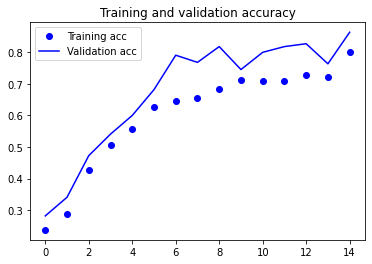

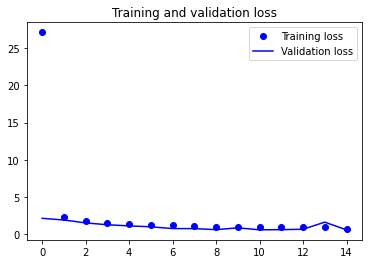

In [26]:
#visualize the model
visualize(history)

# Try using another model(Xception)

In [27]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
image_size = (150, 150)
batch_size = 32

Xception with diffrent preprocessing Function

In [29]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    "/content/clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [30]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "/content/clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


In [31]:
#from focal_loss import SparseCategoricalFocalLoss

def make_model(learning_rate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vector)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [32]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,patience=3,verbose=1),
             keras.callbacks.ModelCheckpoint(
        "xception_v1_.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )]


In [33]:
model = make_model(learning_rate=0.001)
history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds,callbacks=callbacks)

83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/10
96/96 [==============================] - 27s 229ms/step - loss: 1.1192 - accuracy: 0.6167 - val_loss: 0.7297 - val_accuracy: 0.7771 - lr: 0.0010
Epoch 2/10
96/96 [==============================] - 19s 199ms/step - loss: 0.6461 - accuracy: 0.7784 - val_loss: 0.6571 - val_accuracy: 0.7801 - lr: 0.0010
Epoch 3/10
96/96 [==============================] - 19s 201ms/step - loss: 0.5146 - accuracy: 0.8305 - val_loss: 0.5763 - val_accuracy: 0.8240 - lr: 0.0010
Epoch 4/10
96/96 [==============================] - 19s 195ms/step - loss: 0.4404 - accuracy: 0.8615 - val_loss: 0.5512 - val_accuracy: 0.8211 - lr: 0.0010
Epoch 5/10
96/96 [==============================] - 19s 194ms/step - loss: 0.3803 - accuracy: 0.8817 - val_loss: 0.5489 - val_accuracy: 0.8240 - lr: 0.0010
Epoch 6/10
96/96 [==============================] - 19s 200ms/step - loss: 0.3304 - accuracy: 0.9078 - val_loss: 0.5179 - val_accuracy: 0.8475 - lr: 0.0010

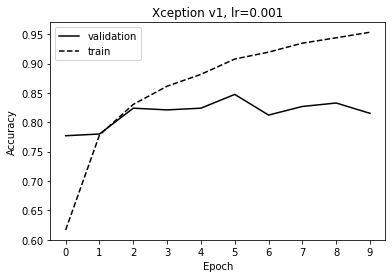

In [34]:
plt.figure(figsize=(6, 4))

epochs = history_0_001.epoch
val = history_0_001.history['val_accuracy']
train = history_0_001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('xception_v1_0_001.svg')

plt.show()

# Data Augmentation with a Large Inception model

In [35]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(299, 299, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(299, 299, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [36]:
image_size = (299, 299)
batch_size = 32

In [37]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    "/content/clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [38]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "/content/clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


In [39]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,patience=3,verbose=1),
             keras.callbacks.ModelCheckpoint(
        "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )]
history_l = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20
96/96 [==============================] - 103s 1s/step - loss: 0.8236 - accuracy: 0.7288 - val_loss: 0.4532 - val_accuracy: 0.8416 - lr: 0.0010
Epoch 2/20
96/96 [==============================] - 98s 1s/step - loss: 0.4528 - accuracy: 0.8491 - val_loss: 0.4000 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 3/20
96/96 [==============================] - 94s 978ms/step - loss: 0.3718 - accuracy: 0.8686 - val_loss: 0.4076 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 4/20
96/96 [==============================] - 95s 983ms/step - loss: 0.3260 - accuracy: 0.8830 - val_loss: 0.3870 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 5/20
96/96 [==============================] - 94s 980ms/step - loss: 0.2989 - accuracy: 0.9038 - val_loss: 0.3807 - val_accuracy: 0.8739 - lr: 0.0010
Epoch 6/20
96/96 [==============================] - 94s 979ms/step - loss: 0.2708 - accuracy: 0.9022 - val_loss: 0.3641 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 7/20
96/96 [==============================] - 94s 978ms/step - 

In [40]:
model.save('/content/drive/MyDrive/Mfinal.h5')

In [41]:
model = keras.models.load_model('/content/drive/MyDrive/Mfinal.h5')

In [42]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    "/content/clothing-dataset-small/test",
    shuffle=False,
    target_size=image_size,
    batch_size=32,
)

Found 372 images belonging to 10 classes.


In [43]:
model.evaluate(test_ds)

12/12 [==============================] - 9s 656ms/step - loss: 0.2726 - accuracy: 0.8978


[0.27264559268951416, 0.897849440574646]

The model performs even better than in the validation data: 90% on test vs 89% on validation

In [44]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [45]:
def make_model(learning_rate, droprate):
    base_model = MobileNetV2(
        weights='imagenet',
        input_shape=(224, 224, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [46]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,patience=3,verbose=1),
             keras.callbacks.ModelCheckpoint(
        "MobileNetV2.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )]
history_l = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=callbacks)

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/20
96/96 [==============================] - 84s 824ms/step - loss: 1.0094 - accuracy: 0.6682 - val_loss: 0.5350 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 2/20
96/96 [==============================] - 76s 790ms/step - loss: 0.4894 - accuracy: 0.8331 - val_loss: 0.4401 - val_accuracy: 0.8651 - lr: 0.0010
Epoch 3/20
96/96 [==============================] - 76s 787ms/step - loss: 0.3809 - accuracy: 0.8667 - val_loss: 0.4092 - val_accuracy: 0.8651 - lr: 0.0010
Epoch 4/20
96/96 [==============================] - 77s 803ms/step - loss: 0.3198 - accuracy: 0.8921 - val_loss: 0.3809 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 5/20
96/96 [==============================] - 77s 802ms/step - loss: 0.2651 - accuracy: 0.9029 - val_loss: 0.3959 - val_accuracy: 0.8563 - lr: 0.0010
Epoch 6/20
96/96 [==============================] - 77s 799ms/step - loss: 0.2360 - accuracy: 0.9169 - val_loss: 0.4704 - val_accuracy: 0.8534 - lr: 0.0010
E

The model achieves the same accursay as the xception model but the mobilenet_v2 is so light weight compare to the xception and vgg models  

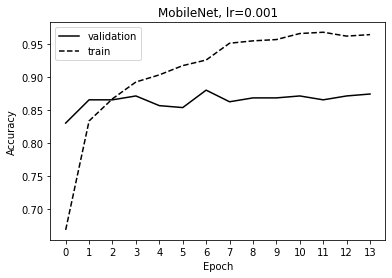

In [47]:
plt.figure(figsize=(6, 4))

epochs =history_l.epoch
val = history_l.history['val_accuracy']
train = history_l.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('MobileNet, lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('MobileNet.svg')

plt.show()


In [48]:
model.save('/content/drive/MyDrive/MobileNet_v2.h5')

*Evaluate the model on the testing data*

In [50]:
model.evaluate(test_ds)

12/12 [==============================] - 4s 261ms/step - loss: 0.3311 - accuracy: 0.8817


[0.33106353878974915, 0.8817204236984253]